[X] Lindbladian computation 

[X] Creation of spin operators and Hamiltonians 

[X] Implementation of RK4 integrator

Work for the future:
- Implement more complicated operations such as partial transposition, partial trace, von Neumann entropy computations

In [130]:
using LinearAlgebra
using Kronecker

In [131]:
function ComputeLindbladian(H,Clist,rho)
    """
    ComputeLindbladian computes the action of Lindblad operator.
    H: Hamiltonian of the system
    C_list: list of Lindblad operators
    rho: density matrix
    ---------------------------------------
    Returns: L*rho
    """
    Lrho = -1im*(H*rho-rho*H)
    for i in 1:length(Clist)
        Lrho += Clist[i]*rho*adjoint(Clist[i]) -0.5*adjoint(Clist[i])*Clist[i]*rho - 0.5*rho*adjoint(Clist[i])*Clist[i]
    end 
    return Lrho
end

function SpinOps(S)
    """
    SpinOps computes the spin operators for arbitrary S spin value
    """
    D = trunc(Int, 2*S+1)
    Sx, Sy, Sz = zeros(ComplexF64, D, D), zeros(ComplexF64, D, D), zeros(ComplexF64, D, D)
    for i in 1:D
        Sz[i,i] = -S+(i-1)
    end
    for i in 1:D-1
        m = -S +(i-1)
        Sx[i,i+1] = 0.5*sqrt(S*(S+1)-m*(m+1))
        Sx[i+1,i] = 0.5*sqrt(S*(S+1)-m*(m+1))
        Sy[i,i+1] = -0.5 *1im*sqrt(S*(S+1)-m*(m+1))
        Sy[i+1,i] = 0.5 *1im*sqrt(S*(S+1)-m*(m+1))
    end
        
    return Sx, Sy, Sz
end

function MultiOp(O, N, i)
   """
    MultiOp computes a given single particle operator O in the many-body space
    O: single particle operator
    N: Number of particles
    i: site of particle corresponding to O operator
    --------------------------------------
    Returns: O in the many body space
   """
    DimL = size(O)[1]
    if i==1
        Id = 1.0*I(DimL^(N-1))
        OEnlarged = kron(O, Id)
    elseif i ==N
        Id = 1.0*I(DimL^(N-1))
        OEnlarged = kron(Id, O)
    else
        Id1 = 1.0*I(DimL^(i-1))
        Id2 = 1.0*I(DimL^(N-i))
        OEnlarged = kron(Id1,kron(O, Id2))
    end
    return OEnlarged
end

function BuildManyList(O,N)
    """
    BuildMAnyList computes a list of many body operators permiting index
    O: Single particle operator
    N: Number of particles
    """
    OList = []
    for i in 1:N
        push!(OList,MultiOp(O, N, i))
    end
    return OList
end

function BuildHamiltonian(Jx, Jy, Jz, hx, hy, hz, Sx_list, Sy_list, Sz_list, N)
   """
    BuildHamiltonian builds the Heisenberg Hamiltonian for an N spin systems
    Jx, Jy, Jz: Heisenberg exhange parameters 
    hx, hy, hz: External Magnetic field terms
    Sx_list, Sy_list, Sz_list: List of many-body spin operators
    N: Number of particle
   """
    H = hx[1]*Sx_list[1]
    for i in 1:N
        H += hy[i] * Sy_list[i]
        H += hz[i] * Sz_list[i]
    end
    
    for i in 1:N-1
        H += Jx[i] * Sx_list[i]*Sx_list[i+1]
        H += Jy[i] * Sy_list[i]*Sy_list[i+1]
        H += Jz[i] * Sz_list[i]*Sz_list[i+1]
        H += hx[i+1] * Sx_list[i+1]
    end
    
    H += Jx[N] * Sx_list[N]*Sx_list[1]
    H += Jy[N] * Sy_list[N]*Sy_list[1]
    H += Jz[N] * Sz_list[N]*Sz_list[1]
    
    return H
end

function AssembleSys(Jx, Jy, Jz, hx, hy, hz, N, S)
    """
    AssembleSys creates the hamiltonian and observables of a given Heisenberg model
    Jx, Jy, Jz: Heisenberg parameters
    hx, hy, hz: External magnetic field
    N: Number of particles
    S: Spin maximum z proyection
    """
    Sx, Sy, Sz = SpinOps(S)
    Sx_list = BuildManyList(Sx,N)
    Sy_list = BuildManyList(Sy,N)
    Sz_list = BuildManyList(Sz,N)
    H = BuildHamiltonian(Jx, Jy, Jz, hx, hy, hz, Sx_list, Sy_list, Sz_list, N)
    return H, Sx_list, Sy_list, Sz_list
end

function IntegrateRK4(rho, H, CList, DeltaT)
    """
    IntegrateRK4 performs numerical integration of the Lindblad equation
    rho: density matrix
    H: Hamiltonian
    CList: Lindblad operators
    DeltaT: time interval
    """
    K1 = ComputeLindbladian(H,CList,rho)
    K2 = ComputeLindbladian(H,CList,rho+DeltaT/2*K1)
    K3 = ComputeLindbladian(H,CList,rho+DeltaT/2*K2)
    K4 = ComputeLindbladian(H,CList,rho+DeltaT*K3)
    
    return rho + 1/6*(K1+2*K2+2*K3+K4)*DeltaT
end

function Measure(rho, O)
    """
    Measure computes the mean value of a given observable
    rho: Density matrix
    O: observable (in many-body representation)
    """
    return real(tr(rho*O))
end

function IntegrateFull(rho, H, CList, DeltaT, NMax, Sx_list, Sy_list, Sz_list, N)
    """
    IntegrateFull performs full integration over the time domain, Observables are measured as time progress
    rho: Density matrix
    H: Hamiltonian
    CList: Lindblad operators
    DeltaT: Time interval
    NMax: Maxximun number of time integrations
    Sx_list, Sy_list, Sz_list: list of observables
    N: Number of particles
    """
    SX = zeros(NMax,N)
    SY = zeros(NMax,N)
    SZ = zeros(NMax,N)
    
    for i in 1:NMax
        for j in 1:N
            SX[i,j] = Measure(rho, Sx_list[j])
            SY[i,j] = Measure(rho, Sy_list[j])
            SZ[i,j] = Measure(rho, Sz_list[j])
        end
        rho = IntegrateRK4(rho, H, CList, DeltaT)
    end
    
    return SX, SY, SZ
end

function BuildInitialS(theta, phi, Sx, Sy, Sz)
    """
    BuildInitialS constructs the initial many body state
    theta, phi: angular orientation 
    Sx, Sy, Sz: quantum angular oerators
    N: Number of particles
    """
    Hp = cos(theta)*Sz + sin(theta)*cos(phi)*Sx+ sin(theta)*sin(phi)*Sy
    A = eigvecs(Hp)
    return A[:,1]
    
end

function BuildManyS(SingleState, N)
    ManyBody = SingleState
    for i in 1:N-1
        ManyBody = kron(ManyBody, SingleState)
    end
    return ManyBody
end

BuildManyS (generic function with 1 method)

Now that most of the essential functionalities for Lindblad integration are completed, we focus on the implementation of the fixed low rank approximation. There are several steps to be completed.

IMPORTANT: NEED TO GENERALIZE FORMALISM TO ALLOW MORE THAN ONE LINDBLAD OPERATOR (DONE)

[X] Evolve free (has to be used twice)
 
[X] Update both patrices accounting for Lindblad terms

[X] Guarantee positivity

[X] Implement orthonormalization routine

[X] Implement initialization of the density matrix.

[X] Implement observables and measurements

[ ] Assemble all functions into a single builder

- Work for future: Consider more general initial scenarios

In [171]:
function FreeEvolve(U, Uevolve)
    """
    FreeEvolve applies taylor expansion to calculate the unitary, free, evolution of U matrix which is the matrix
    containing relevant vectors in the low rank appriximation
    U: Low rank approximation matrix
    Uvevolve: unitary evolution operator 
    """
    return Uevolve*U
end

function OptFreeEvolve(U, H, DeltaT)
    """
    OptFreeEvolve applies free evolution in an efficient fashion
    """
    return U - 1im*DeltaT/2*(H*U)-DeltaT^2/8*(H*(H*U))+1im*DeltaT^3/48*(H*(H*(H*U)))
end

function CreateUevolve(H, DeltaT)
    """
    CreateUevolve computes the approximate evolution operator
    H: Hamiltonian of the system
    DeltaT: Time step
    """
    D = size(H)[1]
    return 1.0*I(D)-1im*DeltaT/2*H-DeltaT^2/8*H*H+1im*DeltaT^3/48*H*H*H
end

function UpdateU(U, CList, sigma, DeltaT)
    """
    UpdateU is an intermediate computation in the numerical integration of low rank Lindblad equation
    U: Matrix of relevent vectors of reduced space
    CList: list of Lindblad operators
    Sigma: reduced density matrix
    DeltaT: time step
    """
    A = U*adjoint(U)
    Sigmainv = inv(sigma)
    D = size(A)[1]
    Up = U
    # Recurrent matrix operations are precomputed to increase performance
    Prefact=DeltaT*(1.0I(D)-A)
    Prefact1 = U*sigma*adjoint(U)
    Prefact2 = U*Sigmainv
    for i in 1:length(CList)
        Up += Prefact*(-0.5*adjoint(CList[i])*(CList[i]*U)+CList[i]*Prefact1*adjoint(CList[i])*Prefact2)
    end
    return Up
end

function Updatesigma1(U, CList, sigma, DeltaT)
    """
    Updatesigma1 carries the first aprt of the numerical integration of reduced density matrix
    U: relevant vector matrix
    CList: Lindblad operators list
    sigma: reduced density matrix
    DeltaT: time step
    """
    sigmap =sigma
    D = size(sigma)[1]
    Prefact1 = U*sigma*adjoint(U)
    for i in 1:length(CList)
        sigmap += DeltaT * adjoint(U)*CList[i]*Prefact1*adjoint(CList[i])*U
        sigmap += DeltaT *1.0*I(D)*tr((adjoint(U)*(adjoint(CList[i])*(CList[i]*U))-(adjoint(U)*adjoint(CList[i]))*U*adjoint(U)*(CList[i]*U))*sigma)/D
    end
    return sigmap
end

function Updatesigma2(U, CList, sigma, DeltaT)
    """
    Updatesigma2 performs the second part of the numerical intagration of the reduced density matrix this part is done
    to ensure positivity and nice properties Lindblad equation is supposed to have
    U: relevant vector matrix
    CList: Lindblad operators
    sigma: reduced density matrix
    DeltaT: time step
    """
    D = size(sigma)[1]
    Lp = 1.0*I(D)
    for i in 1:length(CList)
        Lp -= DeltaT/2*adjoint(U)*adjoint(CList[i])*CList[i]*U
    end
    sigmap = Lp*sigma*Lp/tr(Lp*sigma*Lp)
    return sigmap
end

function Orthogonalize(U,m)
    q,r = qr(U)
    q_par = zeros(ComplexF64,size(U)[1], size(U)[2])
    for i in 1:m
        if real(U[:,i]'*q[:,i])<0
            q_par[:,i] = -q[:,i]
        else
            q_par[:,i] = q[:,i]
        end
    end
    return q_par[:,1:m]
end

function Startsigma(m, eps)
    """
    Startsigma starts sigma assuming initial density matrix is a pure state
    m: low rank
    eps: tol default is suggested to be 1e-5
    """
    dia = ones(m)
    dia[1] *= 1-(m-1)*eps
    dia[2:m] *= eps
    sigma = diagm(dia)
    return sigma
end

function StartU(m,H,psi_0)
    """
    StartU starts U the matrix of important vectors
    m: low rank 
    H: Full Hamiltonian
    psi_0: initial wavefunction
    """
    DH = size(H)[1]
    U = zeros(DH,m)
    U[:,1] = psi_0
    for i in 2:m
        U[:,i] = H*U[:,i-1]
    end
    q,r =qr(U)
    q_par = zeros(ComplexF64,size(U)[1], size(U)[2])
    for i in 1:m
        if real(U[:,i]'*q[:,i])<0
            q_par[:,i] = -q[:,i]
        else
            q_par[:,i] = q[:,i]
        end
        q_par[:,i] = q[:,i]
    end
    return q_par[:,1:m]
end

function MeasureLowRank(O, sigma, U)
    """
    MeasureLowRank performs a measuremt using the low rank method
    Optimal matrix multiplication is used
    O: Observable
    sigma: low rank density matrix
    U: Transformation matrix
    """
    return real(tr((O*U)*sigma*adjoint(U)))
end

function SingleLowIntegrate(U, sigma, Uevolve, CList, DeltaT)
    """
    SingleLowRank unites all previously defined integrating functions for a single time step evolution
    """
    U = FreeEvolve(U, Uevolve)
    # Second update of U is not used in the evolution of sigma
    Up = UpdateU(U, CList, sigma, DeltaT)
    sigma = Updatesigma1(U, CList, sigma, DeltaT)
    sigma = Updatesigma2(U, CList, sigma, DeltaT)
    U = FreeEvolve(Up, Uevolve)
    m = size(U)[2]
    U = Orthogonalize(U,m)
    return U, sigma
end

function ComputeParNorm(U,sigma, H, CList)
    """
    ComputeParNorm calculates the Frobenius norm of the 'parallel' part of the differential equation
    U: Transformation matrix
    sigma: reduced density matrix
    H: Hamiltonian
    CList: List of Lindblad operators
    """
    D = -1im * ((H*U)*sigma)*adjoint(U)
    D += +1im *U*(sigma*(adjoint(U)*H))
    for i in 1:length(CList)
        D += CList[i]*U*sigma*adjoint(U)*adjoint(CList[i]) 
        D += - 0.5*(adjoint(CList[i])*(CList[i]*U))*sigma*adjoint(U) 
        D += - 0.5*U*sigma*((adjoint(U)*adjoint(CList[i]))*CList[i]) 
    end
    return norm(D)
end

function ComputeFullNorm(U,sigma, H, CList)
    m = size(sigma)[1]
    Pr = U*adjoint(U)
    Op = 1.0*I(size(H)[1])-Pr
    D = -1im * ((H*U)*sigma)*adjoint(U)
    D += +1im *U*(sigma*(adjoint(U)*H))
    for i in 1:length(CList)
        D += CList[i]*U*sigma*adjoint(U)*adjoint(CList[i]) 
        D += - 0.5*(adjoint(CList[i])*(CList[i]*U))*sigma*adjoint(U) 
        D += - 0.5*U*sigma*((adjoint(U)*adjoint(CList[i]))*CList[i]) 
        D += (Op*(CList[i]*U))*sigma*((adjoint(U)*adjoint(CList[i]))*Op)
        D -= tr((adjoint(CList[i])*(Op*(CList[i]*U)))*sigma*adjoint(U))/m*Pr
    end
    return norm(D)
end

function ComputePerNorm(U, sigma, H, CList)
    """
    ComputePerNorm calculates the Frobenius norm of the 'perpedicular' part of the differential equation
    U: Transformation matrix
    sigma: reduced density matrix
    H: Hamiltonian
    CList: List of Lindblad operators
    """
    m = size(sigma)[1]
    Pr = U*adjoint(U)
    Op = 1.0*I(size(H)[1])-Pr
    D = (Op*(CList[1]*U))*sigma*((adjoint(U)*adjoint(CList[1]))*Op)
    D -= tr((adjoint(CList[1])*(Op*(CList[1]*U)))*sigma*adjoint(U))/m*Pr
    
    for i in 2:length(CList)
        D += (Op*(CList[i]*U))*sigma*((adjoint(U)*adjoint(CList[i]))*Op)
        D -= tr((adjoint(CList[i])*(Op*(CList[i]*U)))*sigma*adjoint(U))/m*Pr
    end
    return norm(D)
end
    

function IntegrateLowRank(U, sigma, H, Clist, DeltaT, Nmax, Sx_list, Sy_list, Sz_list, N)
    """
    IntegrateLowRank Performs low rank integration and computes observables
    U, sigma: Low rank matrices
    H: Hamiltonian
    CList: list of Lindblad operators
    DeltaT: time step
    Nmax: Maximum number of iterations
    Sx_list, Sy_list, Sz_list: observables
    N: Number of particles
    """
    Uevolve = CreateUevolve(H, DeltaT)
    SX, SY, SZ = zeros(Nmax, N), zeros(Nmax, N), zeros(Nmax, N)
    # Eigenvalues tracking of reduced density matrix is useful to quatify the error
    Uval = zeros(Nmax, size(sigma)[1])
    Aux= zeros(16,4)
    NormPar = zeros(Nmax)
    NormPer = zeros(Nmax)
    for i in 1:Nmax
        Uval[i,:]= real(eigvals(sigma))
        NormPar[i] = ComputeFullNorm(U,sigma, H, CList)
        NormPer[i] = ComputePerNorm(U,sigma, H, CList)
        U, sigma = SingleLowIntegrate(U, sigma, Uevolve, CList, DeltaT)
        for j in 1:N
            SX[i,j] = MeasureLowRank(Sx_list[j], sigma, U)
            SY[i,j] = MeasureLowRank(Sy_list[j], sigma, U)
            SZ[i,j] = MeasureLowRank(Sz_list[j], sigma, U)
        end
    end
    return SX, SY, SZ, Uval, NormPar, NormPer
end

IntegrateLowRank (generic function with 1 method)

Let's try to run it. First let's try regular Lindblad integrator

In [179]:
using BenchmarkTools
N=4
S = 0.5
# First set up Hamiltonian
Jx, Jy, Jz =-0.1*ones(N), -0.1*ones(N), -0.1*ones(N)
hx, hy, hz = 0*ones(N), 0*ones(N), 0.8*ones(N)
Sx, Sy, Sz = SpinOps(S)
H, Sx_list, Sy_list, Sz_list = AssembleSys(Jx, Jy, Jz, hx, hy, hz, N, S)

# Set up Initial wavefunction
Si = BuildInitialS(0.4, 0, Sx, Sy, Sz)
psi0 = BuildManyS(Si, N)
rho0 = psi0 * psi0'

# Set up Lindblad operators
CList = []
for i in 1:N
    push!(CList, Sx_list[i]-1im*Sy_list[i])
end

# Integrate Lindblad equations
DeltaT=0.01
NMax = 500
SX, SY, SZ = IntegrateFull(rho0, H, CList, DeltaT, NMax, Sx_list, Sy_list, Sz_list, N);

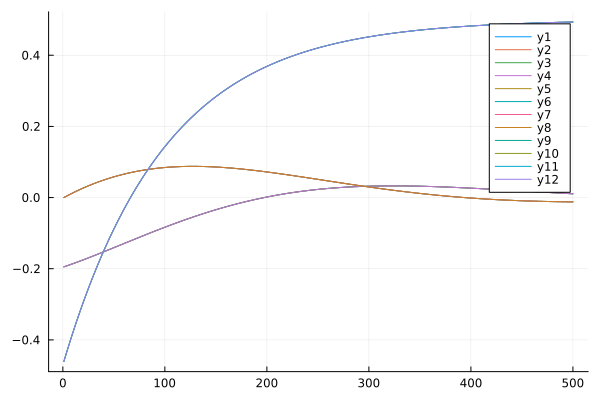

In [180]:
using Plots
plot(SX)
plot!(SY)
plot!(SZ)

WORK FOR FUTURE:

[ ] Compare Qutip with| my code, do some benchmarks comparisons

Now, let's test low rank approximation.

In [226]:
# Start low rank matrices
m = 15
eps = 1e-5
sigma = Startsigma(m, eps)
U = StartU(m,H,psi0);

In [227]:
SXL, SYL, SZL, Uval, NPar, NPer= IntegrateLowRank(U, sigma, H, CList, DeltaT, NMax, Sx_list, Sy_list, Sz_list, N);

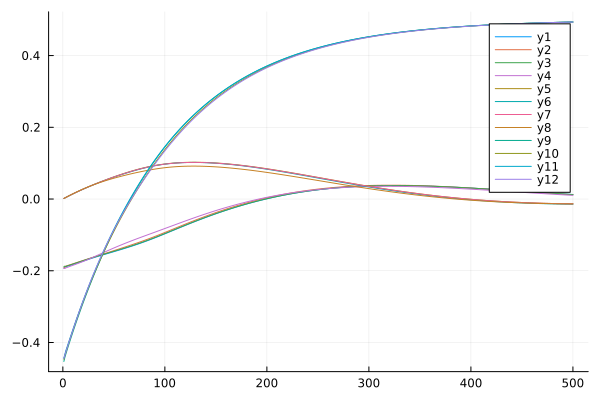

In [228]:
plot(SXL)
plot!(SYL)
plot!(SZL)

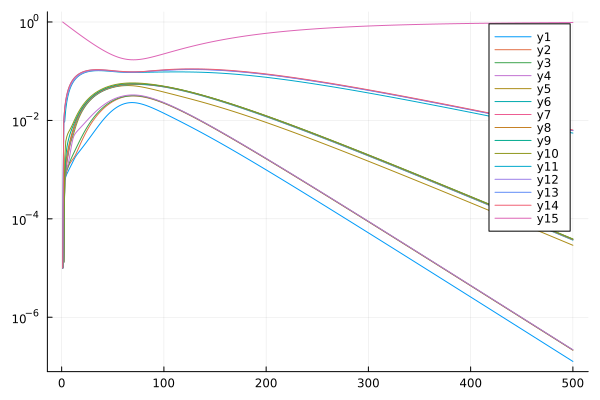

In [229]:
plot(Uval,yaxis=:log)

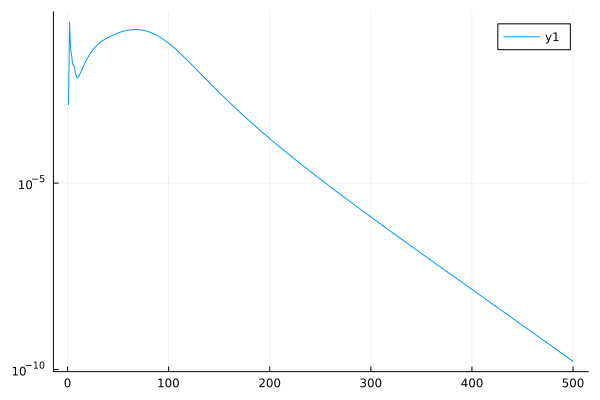

In [230]:
plot(NPer./NPar, yaxis=:log)